In [1]:
from circuit_builder import ParameterizedQuantumCircuit as PQC, BlockSequence
from circuit_builder import *
import numpy as np
import torch

seed = 808
np.random.seed(seed)
torch.manual_seed(seed)
np.bool8 = np.bool_  # Prevent deprecation warning

<p align="center">
    <img src="images/HEA-layers.png" alt="drawing" width="800"/>
</p>
<p align="center">
    <img src="images/one-gate.png" alt="drawing" width="300"/>
</p>
<p align="center">
    <img src="images/multiple-gates.png" alt="drawing" width="800"/>
</p>

In [2]:
model = PQC.speedrun('CartPole-v1')
model.train()

Environment solved in 60 episodes! Reward=500.00

Training completed. Best reward: 500.00
Animation saved to outputs/best_performance.gif


![Animation](outputs/best_performance.gif)

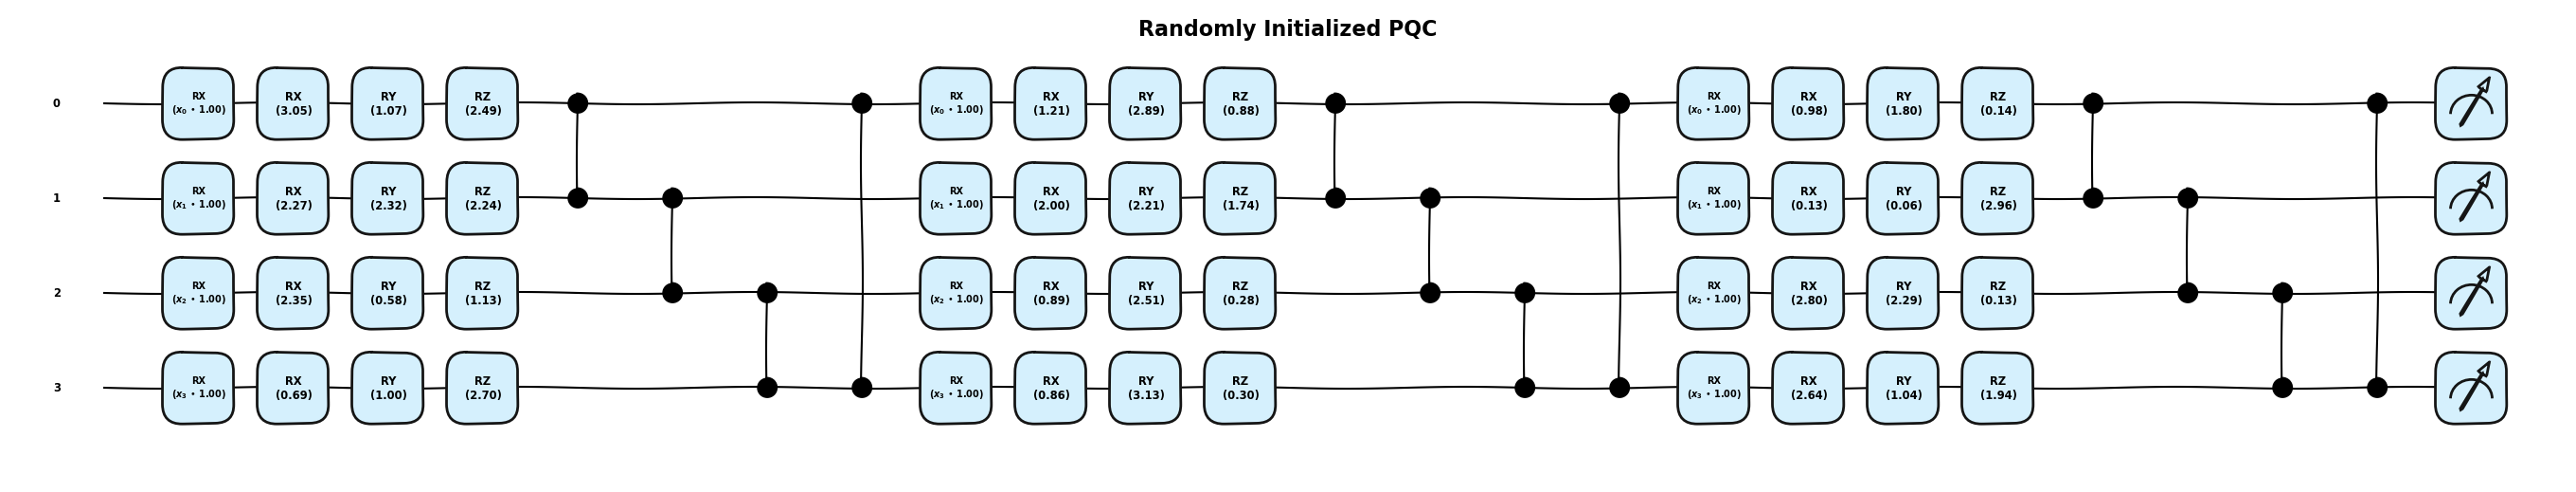

In [3]:
sequence = (BlockSequence()
    .EncodingLayer()
    .VariationalLayer()
    .EncodingLayer()
    .VariationalLayer()
    .EncodingLayer()
    .VariationalLayer()
)

model = ParameterizedQuantumCircuit(
    env_name='CartPole-v1',
    n_qubits=4,
    beta=1.0,
    custom_blocks=sequence,
)

model.draw_circuit(
    style='pennylane_sketch',
    fontsize='small',
    dpi=300,
    title='Randomly Initialized PQC'
)

model.train(
    gamma=1.0,
    plot=True,
    save=False,
    animate=False,
    early_stopping=False,
    return_histories=False
)

model.draw_circuit(
    style='pennylane_sketch',
    fontsize='small',
    dpi=300,
    title='Trained PQC'
)